In [1]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')


import utils.basics as bsc
import utils.plotting as pt

import importlib
importlib.reload(pt)

%load_ext autoreload
%autoreload 2


## Loading files

In [3]:
# PATHS
S2_stacked_1 = "../data/02_processed/S2_Stacked_Site_1.tif"
S2_stacked_2 = "../data/02_processed/S2_Stacked_Site_2.tif"
ALS_PATH1_RES = "../data/02_processed/ALS_resampled_site1.tif"
ALS_PATH2_RES = "../data/02_processed/ALS_resampled_site2.tif"

In [5]:
# Load S2 and merged ALS data for both sites and combine them in an array
s2_np, als_np = bsc.load_rasters(S2_stacked_1, ALS_PATH1_RES,verbose=False)
s2_np2, als_np2 = bsc.load_rasters(S2_stacked_2, ALS_PATH2_RES,verbose=False)

## Do Patch extraction

In [2]:
def extract_patches_with_resampled_data(s2, als, patch_size, only_full_patches=False):
    """
    Extract patches from S2 data and resampled ALS data.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als: numpy array of resampled ALS values (height, width)
    - patch_size: size of the patches to extract
    - only_full_patches: if True, only return patches with no NaN/missing data

    Returns:
    - s2_patches: numpy array of S2 patches
    - als_patches: numpy array of ALS ground truth patches
    - combined_patches: numpy array of combined patches (S2 + ALS as additional band)
    """
    _, h, w = s2.shape
    patches_s2, patches_als, combined_patches = [], [], []
    full_patch_count = 0

    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            s2_patch = s2[:, i:i+patch_size, j:j+patch_size]
            als_patch = als[i:i+patch_size, j:j+patch_size]

            combined_patch = np.concatenate(
                [s2_patch, als_patch[np.newaxis, :, :]], axis=0
            )

            has_nan = np.isnan(combined_patch).any()
            if not has_nan:
                full_patch_count += 1

            if only_full_patches and has_nan:
                continue

            patches_s2.append(s2_patch)
            patches_als.append(als_patch)
            combined_patches.append(combined_patch)

    s2_arr = np.stack(patches_s2) if patches_s2 else np.empty((0, s2.shape[0], patch_size, patch_size))
    als_arr = np.stack(patches_als) if patches_als else np.empty((0, patch_size, patch_size))
    combined_arr = np.stack(combined_patches) if combined_patches else np.empty((0, s2.shape[0]+1, patch_size, patch_size))

    print(f"Patch size: {patch_size}, Number of patches: {len(s2_arr)}, Full patches (no NaN): {full_patch_count}")
    return s2_arr, als_arr, combined_arr


In [13]:
patches = [32,64,128,256]
s2 = [s2_np, s2_np2]
als = [als_np, als_np2]
i = 0
for s2, als in zip(s2, als):
    i+= 1
    print(f"Processing site {i}...")
    print("---------------------")
    print(f"S2 shape: {s2.shape}, ALS shape: {als.shape}")
    for p in patches:
        #print(f"Extracting patches of size {p}...")
        s2_arr, als_arr, combined_arr = extract_patches_with_resampled_data(s2, als, p, only_full_patches=False)
    print("---------------------")

Processing site 1...
---------------------
S2 shape: (13, 846, 1241), ALS shape: (846, 1241)
Patch size: 32, Number of patches: 988, Full patches (no NaN): 360
Patch size: 64, Number of patches: 247, Full patches (no NaN): 65
Patch size: 128, Number of patches: 54, Full patches (no NaN): 9
Patch size: 256, Number of patches: 12, Full patches (no NaN): 0
---------------------
Processing site 2...
---------------------
S2 shape: (13, 1002, 815), ALS shape: (1002, 815)
Patch size: 32, Number of patches: 775, Full patches (no NaN): 319
Patch size: 64, Number of patches: 180, Full patches (no NaN): 53
Patch size: 128, Number of patches: 42, Full patches (no NaN): 5
Patch size: 256, Number of patches: 9, Full patches (no NaN): 0
---------------------


## some intuitiuon plotting

Patch size: 128, Number of patches: 5, Full patches (no NaN): 5


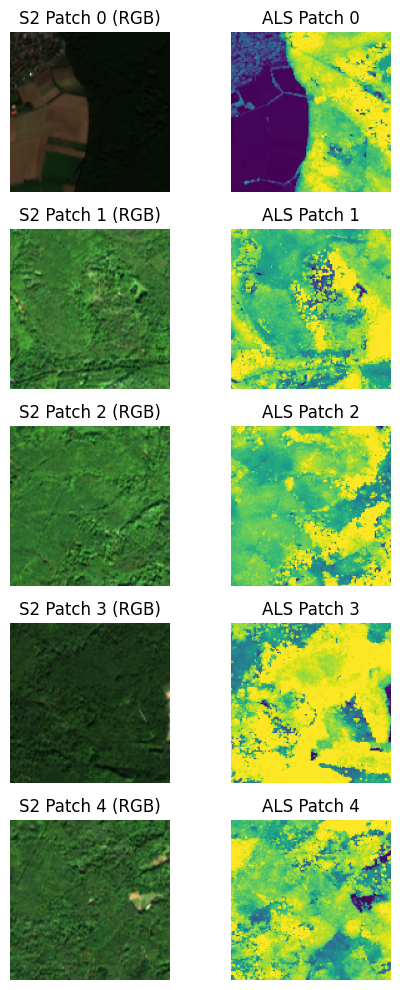

In [26]:
p = 128
s2 = s2_np2 #[s2_np, 
als = als_np2 #[als_np, als_np2]

s2_arr, als_arr, combined_arr = extract_patches_with_resampled_data(s2, als, p, only_full_patches=True)

# plot some patches directly here
n_patches = 5
fig, axes = plt.subplots(n_patches, 2, figsize=(5, 2 * n_patches))

for idx in range(n_patches):
    # S2 RGB composite (bands 10, 3, 0 if available)
    if s2_arr.shape[1] >= 4:
        rgb = np.stack([
            s2_arr[idx, 10],  # band 10 (red)
            s2_arr[idx, 3],  # band 3 (green)
            s2_arr[idx, 0],  # band 0 (blue)
        ], axis=-1)
        rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb) + 1e-6)
        axes[idx, 0].imshow(rgb)
        axes[idx, 0].set_title(f"S2 Patch {idx} (RGB)")
    else:
        axes[idx, 0].imshow(s2_arr[idx, 0], cmap='gray')
        axes[idx, 0].set_title(f"S2 Patch {idx} (Band 0)")

    # ALS patch
    axes[idx, 1].imshow(als_arr[idx], cmap='viridis')
    axes[idx, 1].set_title(f"ALS Patch {idx}")


    for j in range(2):
        axes[idx, j].axis('off')

plt.tight_layout()
plt.show()
